In [1]:
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import numpy as np
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img
%matplotlib inline

In [5]:
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              rescale=1/255,
                              fill_mode="nearest",
                              validation_split=0.1) # set validation split

print(image_gen.flow_from_directory("/content/drive/MyDrive/test data/test_data"))

Found 5181 images belonging to 11 classes.


In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, AveragePooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [7]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model2')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(224, 80, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu'))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
      
    # output layer:
    model.add(Dense(512, activation='elu'))  # not in original model. added for more robustness
    model.add(Dense(11,activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 38, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 17, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 7, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 5, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 23, 5, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 3, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 4032)            

In [10]:
checkpoint_filepath = 'License_plate_nvidia.h5'
# EarlyStopping allows model to stop traning in case loss is not reduced after 5 epochs 
# ModelCheckpoint allosw model to save weight everytime loss is reduced
my_checkpointer = [
                   EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                   ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)
                   ]

In [11]:
input_shape = (224,80,3)
batch_size = 150

train_image_gen = image_gen.flow_from_directory("/content/drive/MyDrive/test data/test_data",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                subset="training")
valid_image_gen = image_gen.flow_from_directory("/content/drive/MyDrive/test data/test_data",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                subset="validation")

Found 4666 images belonging to 11 classes.
Found 515 images belonging to 11 classes.


In [12]:
#model.load_weights("License_plate_nvidia.h5")
result = model.fit_generator(train_image_gen,epochs=40,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=my_checkpointer,verbose=1)

Epoch 1/40
32/32 [==============================] - 715s 22s/step - loss: 2.2194 - accuracy: 0.1984 - val_loss: 1.8100 - val_accuracy: 0.3748

Epoch 00001: val_loss improved from inf to 1.81004, saving model to License_plate_nvidia.h5
Epoch 2/40
32/32 [==============================] - 24s 762ms/step - loss: 1.4219 - accuracy: 0.5091 - val_loss: 1.1778 - val_accuracy: 0.6214

Epoch 00002: val_loss improved from 1.81004 to 1.17785, saving model to License_plate_nvidia.h5
Epoch 3/40
32/32 [==============================] - 24s 746ms/step - loss: 0.7809 - accuracy: 0.7393 - val_loss: 0.7761 - val_accuracy: 0.7359

Epoch 00003: val_loss improved from 1.17785 to 0.77606, saving model to License_plate_nvidia.h5
Epoch 4/40
32/32 [==============================] - 24s 751ms/step - loss: 0.4630 - accuracy: 0.8337 - val_loss: 0.6166 - val_accuracy: 0.8330

Epoch 00004: val_loss improved from 0.77606 to 0.61657, saving model to License_plate_nvidia.h5
Epoch 5/40
32/32 [===========================

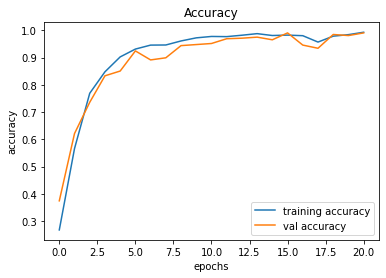

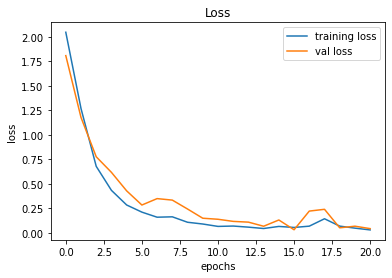

In [13]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
#plt.savefig("Accuracy.png", dpi=300)

plt.figure(1)
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig("Loss.png", dpi=300)

In [14]:
from keras.models import model_from_json
model_json = model.to_json()
with open("License_plate_nvidia.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
adam = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
result2 = model.fit_generator(train_image_gen,epochs=40,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=my_checkpointer,verbose=1)